Input shapes: (75, 5), Output shape: (75, 1)
Concatenated data shape: (75, 6)
(56, 6)
(19, 6)
Error: 0.03383341028377241 at epoch 1 
Error: 0.027567089760223616 at epoch 2 
Error: 0.027566910487973637 at epoch 3 
Error: 0.02756690861812133 at epoch 4 
Error: 0.02756690679406142 at epoch 5 
Error: 0.02756690500541061 at epoch 6 
Error: 0.027566903251145778 at epoch 7 
Error: 0.027566901530283405 at epoch 8 
Error: 0.027566899841877095 at epoch 9 
Error: 0.02756689818501592 at epoch 10 
[19, 0]
the accuracy is 100.0000 %


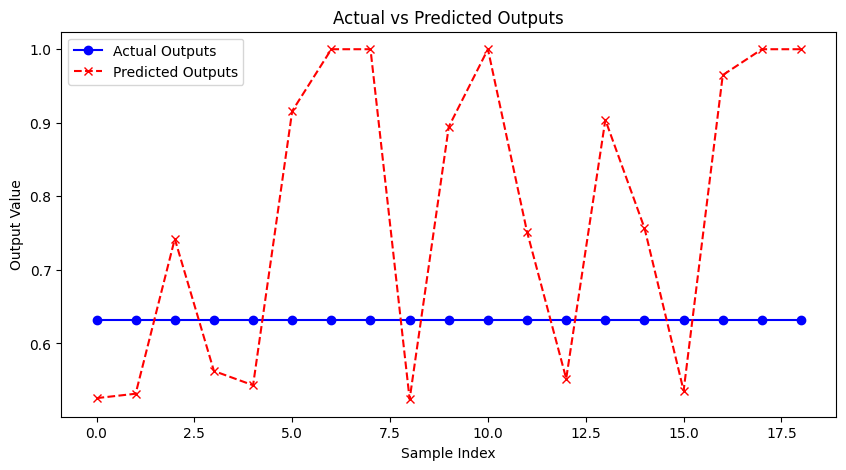

In [ ]:
import numpy as np
import pandas as pd
from pickle import TRUE
from random import random
import matplotlib.pyplot as plt

PRED_ERROR = 0.2

class Neural_Network:

    # initialize the neural network
    def __init__(self, num_inputs, num_hidden , num_outputs):
        self.num_inputs = num_inputs   # num_inputs = number of nodes in the input layer 
        self.num_hidden = num_hidden   # num_hidden = number of nodes in the hidden layers i.e: hidden_layers_size [20, 30] it has 2 hidden layers first hidden layer has
                                       # 20 nodes and the second hidden layer has 30 nodes
        self.num_outputs = num_outputs # num_outputs = number of nodes in the output layer
        layers = [self.num_inputs] + self.num_hidden + [self.num_outputs] # obtain a list that represents the size of each layer in the neural network.
                                       # i.e: self.num_inputs = 4, self.num_hidden = [8, 16], and self.num_outputs = 3, then layers will be equal to [4, 8, 16, 3]

        # initiate weights
        self.weights = []      # an empty weights list
        self.prev_weights = [] # storing previous weights list 
        self.momentumterm = []

        # initialize the weights randomly
        for i in range(len(layers) - 1): 
            w = np.random.rand(layers[i] , layers[i+1]) # list of weight matrices which has rows and columns to the corresponding layer and the one after it
            self.weights.append(w)

        activations = []             # empty list created to store the activations (outputs) of each layer of the neural network during the forward propagation
        for i in range(len(layers)): # iterating through layers and storing them in the activation list
            a = np.zeros(layers[i])
            activations.append(a)
        self.activations = activations

        derivatives = [] # list to store the derivatives of the weights between each layer during backpropagation
        for i in range(len(layers)-1):
            d = np.zeros((layers[i], layers[i+1])) 
            derivatives.append(d)
        self.derivatives = derivatives

    def feedforward(self, inputs):
        activations = inputs # Set the input layer activations to the input values
        self.activations[0]= inputs # Store the input layer activations in self.activations[0]
        for i, w in enumerate(self.weights): # Iterate over the weights while keeping track of the index
            # Calculate net inputs to each layer by taking the dot product of the activations and weights for that layer
            net_inputs = np.dot(activations, w)  
            # Calculate the activation of the layer using the sigmoid activation function
            activations = self.sigmoid(net_inputs)
            # Store the activations for each layer in self.activations
            self.activations[i+1] = activations
        return activations

    def backpropagation(self, error, verbose = False):
        # Loop over the layers in reverse order
        for i in reversed(range(len(self.derivatives))):
            # Get the activations for the current layer
            activations = self.activations[i+1]  
            # Calculate delta, the error multiplied by the derivative of the activation function    
            delta = error * self.sigmoid_derivative(activations)
            # Reshape delta to have dimensions (n, 1) for later dot product operation
            delta_reshaped = delta.reshape(delta.shape[0], -1).T 
            # Get the activations for the previous layer
            current_activations = self.activations[i]
            # Reshape activations to have dimensions (n, 1) for later dot product operation
            current_activations_reshaped = current_activations.reshape(current_activations.shape[0], -1)
            # Calculate the derivative for the current layer                
            self.derivatives[i] = np.dot(current_activations_reshaped, delta_reshaped)
            # Calculate the error for the previous layer using the weights and delta for the current layer
            error = np.dot(delta, self.weights[i].T)

            #verbose is a boolean parameter that is used to control whether or not to print out intermediate results during the backpropagation process
            if verbose:
                print("Derivatives for W{}: {}".format(i, self.derivatives[i]))
        
            # Return the error for the input layer
        return error

   # Update the weights
    def update_weights(self, learning_rate):
        for i in range(len(self.weights)):
            weights = self.weights[i] # Get the current weights
            derivatives = self.derivatives[i] # Get the derivatives of the current layer
            momentum = self.momentumterm[i]
            weights += momentum + derivatives * learning_rate # Update the weights with the momentum and the derivatives multiplied by the learning rate

    def momentum_fct(self, momentum):
        self.saveprev_weights(self.weights)
        for i in range(len(self.weights)):
            weights = self.weights [i]
            savedprev_weights = self.prev_weights[i]
            x = momentum * ( weights - savedprev_weights )
            self.momentumterm.append(x)        
            
    # Save the current weights of the neural network to the prev_weights 
    def saveprev_weights(self, currentweights):
        self.prev_weights.clear()
        for i in range(len(currentweights)):
            self.prev_weights.append(currentweights[i])

    def train(self, inputs, targets, epochs, learning_rate, momentum, verbose = False):
        
        for i in range(epochs):
            sum_error = 0
            for input, target in zip(inputs, targets):
                
                output = self.feedforward(input)

                #calculate error 
                error = (target - output) # desired - actual output

                #back propagation
                self.backpropagation(error)

                #apply momentum formula to update momentum
                self.momentum_fct(momentum)

                #apply gradient descent
                self.update_weights(learning_rate)

                sum_error += self.mse_fct(target, output)
            #report error
            if verbose:
                print("Error: {} at epoch {} ".format(sum_error / len(inputs), i+1))

    def predict(self, testing_set, testing_output_set):
        predictionTable = []
        predicted_outputs = [] # add this line to store the predicted outputs.
        x = 0
        y = 0

        for i , target in enumerate(testing_output_set): 
            output = self.feedforward(testing_set)
            predicted_outputs.append(output[i]) # Append the predicted output to the list 
            error = self.mse_fct(target , output[i])
           
            if error <= PRED_ERROR:
                x += 1
            else:
                y += 1
            predictionTable = [x, y]
        return predictionTable, testing_output_set, predicted_outputs
        
    def mse_fct(self, target, output):
        return np.average((target-output)**2)

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def sigmoid(self,x):
        return (1 / (1 + np.exp(-x)))

    def normalize(a):
        for i in range(a.shape[0]):
            for j in range(a.shape[1]):
                a[i,j] = (a[i,j] - a.min())/(a.max() - a.min())
        return a

    def plot_predictions(testing_output_set, predicted_outputs):
      plt.figure(figsize=(10, 5))
      plt.plot(testing_output_set, label='Actual Outputs', linestyle='-', marker='o', color='b')
      plt.plot(predicted_outputs, label='Predicted Outputs', linestyle='--', marker='x', color='r')
      plt.xlabel('Sample Index')
      plt.ylabel('Output Value')
      plt.title('Actual vs Predicted Outputs')
      plt.legend()
      plt.show()

if __name__ == "__main__": 

    data = pd.read_csv(r"/content/cereals.csv")
    data = np.array(data)
    # We split the dataset into inputs and output
    X = data[:, :-1] # Select all rows and all columns except the last one as input
    y = data[:, -1]  # Select all rows and the last column as output
    y = y.reshape(-1, 1)
    print(f"Input shapes: {X.shape}, Output shape: {y.shape}") # Print the shapes of the input and output data
    TRAINING_PERCENTAGE = 75
    n_epochs = 10
    # Set the number of times the data will be shuffled before each training
    n_datashuffle = 1
    LearningRate = 0.9 
    Momentum = 0.4     
    Neural_Network.normalize(y) # Normalize the output
    data = np.concatenate((X, y), axis=1) # Concatenate the arrays to start training the dataset.
    print(f"Concatenated data shape: {data.shape}") # Print the shape of the concatenated data array
    
    data_training =(data[:int(TRAINING_PERCENTAGE/100 * data.shape[0])])
    data_testing =(data[int(TRAINING_PERCENTAGE/100 * data.shape[0]):])

    mlp = Neural_Network(5, [3] , 1)

    # Shuffle the data and train the neural network multiple times
    for i in range(n_datashuffle):

        # Print the shapes of the training and validation sets
        print(data_training.shape)
        print(data_testing.shape)

        # Extract the inputs and outputs from the training and validation sets
        trainingSet = data_training[:,:5]
        testing_set = data_testing[:,:5]
        trainingTargetSet = data_training[:,5]
        testing_output_set = data_testing[:,5]

        # Train the neural network using the training data
        mlp.train(trainingSet, trainingTargetSet, n_epochs, LearningRate , Momentum, True) 

        # Shuffle the training data for the next iteration
        np.random.shuffle(data_training)

    # Predict validation set using the trained model
    predTable, predicted_outputs, testing_output_set = mlp.predict(testing_set, testing_output_set)

    # Print predicted table and calculate accuracy
    print(predTable)
    accuracyPercentage = predTable[0]*100/(predTable[0] + predTable[1])
    accuracyPercentage="%.4f" % accuracyPercentage
    print("the accuracy is {} %".format (accuracyPercentage))

    Neural_Network.plot_predictions(testing_output_set, predicted_outputs)